# $Import$

In [1]:
import random
import numpy as np
from numba import njit
from datetime import datetime
import csv
import matplotlib.pyplot as plt

# $Function$ $functions$

## 1.Ising Model Matrix(complete)

In [2]:
def weight_matrix(nbit):
    mat = np.zeros((nbit, nbit))
    for ii in range(nbit):
        for jj in range(nbit):
            if jj >= ii: mat[ii, jj] = np.random.uniform(-1, 1)
    return mat

## 2.Save to csv file

In [3]:
def save_file(filename, data):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

## 3.Read csv file

In [4]:
def readcsv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [list(map(float, col)) for col in zip(*reader)]

## 4.Get the mean and std

In [5]:
def calculate(lst):
    arr = np.array(lst)
    mean = np.mean(arr)
    stddev = np.std(arr, ddof=1)
    return mean, stddev

# $Adapt-Clifford$ $Heuristics$(numba)

In [6]:
@njit
def greedy_python(nbit, W, f):
    qubits = np.zeros(nbit, dtype=np.int8)

    if W[f, f] > 0:
        qubits[f] = 1
    exp = -abs(W[f, f])

    active = np.zeros(nbit, dtype=np.int32)
    inactive = np.ones(nbit, dtype=np.bool_)
    active[0] = f
    inactive[f] = False
    active_size = 1

    while active_size < nbit:
        max_grad = 0.0
        max_key = -1

        for j in range(nbit):
            if not inactive[j]:
                continue

            s = W[j, j]
            for k in range(active_size):
                i = active[k]
                if i <= j:
                    w = 2*W[i, j]
                else:
                    w = 2*W[j, i]
                s += ((-1) ** qubits[i]) * w

            if abs(s) > abs(max_grad):
                max_grad = s
                max_key = j

        exp -= abs(max_grad)
        qubits[max_key] = 1 if max_grad > 0 else 0

        active[active_size] = max_key
        active_size += 1
        inactive[max_key] = False

    return qubits, exp

In [7]:
def randm(nbit, W):
    f = random.choice(range(nbit))
    _, exp = greedy_python(nbit, W, f)
    return exp

In [8]:
def deter(nbit, W):
    best_exp = 100
    for f in range(nbit):
        _, exp = greedy_python(nbit, W, f)
        if exp < best_exp:
            best_exp = exp
    return best_exp

# $Baseline$ $greedy$ $algorithm$

In [9]:
def example(nqubit, Q_triu, repeat):
    J = np.triu(Q_triu, k=1) + np.triu(Q_triu, k=1).T
    h = np.diag(Q_triu)
    best_energy = np.inf

    for ii in range(repeat):
        num1 = random.randint(0, nqubit)
        select_num = random.sample(range(nqubit), num1)
        
        bits = np.zeros(nqubit)

        for i in range(nqubit):
            if i in select_num:
                bits[i] = -1
            else:
                bits[i] = 1

        energy = h@bits + bits.T @ J @ bits

        while True:
            delta_E = (2*J @ bits + h) * -2 * bits
            index = np.argmin(delta_E)
            bits[index] = -bits[index]

            if delta_E[index] < 0:
                energy += delta_E[index]
            else:
                break

        if energy < best_energy:
            best_energy = energy
    return best_energy

# $Results$

### code

In [ ]:
task = [200, 400, 600, 800, 1000]

start = datetime.now().strftime("%H:%M:%S")
print("start time:", start)
for nbit in task:
    lst = []
    for num in range(60):
        W = weight_matrix(nbit)
        energy_r = randm(nbit, W)
        energy_d = deter(nbit, W)
        energy_0 = example(nbit, W, 1)
        energy_1 = example(nbit, W, 10)
        energy_2 = example(nbit, W, 100)
        energy_3 = example(nbit, W, 1000)
        end = datetime.now().strftime("%H:%M:%S")
        print(f"{num+1} is done", end)
        lst.append([energy_r, energy_d, energy_0, energy_1, energy_2, energy_3])
    save_file(f"he_n={nbit}.csv", lst)

### run my data

In [10]:
task = [200, 400, 600, 800, 1000]

lsts = [readcsv(f"he_n={i}.csv") for i in task]

aves = [[], [], [], [], [], []]
yerrs = [[], [], [], [], [], []]

for j in range(5):
    for i in range(6):
        ave, yerr = calculate(lsts[j][i])
        aves[i].append(ave/task[j])
        yerrs[i].append(yerr/task[j])

randm_ave = aves[0]
deter_ave = aves[1]
r0_ave = aves[2]
r1_ave = aves[3]
r2_ave = aves[4]
r3_ave = aves[5]

randm_yerr = yerrs[0]
deter_yerr = yerrs[1]
r0_yerr = yerrs[2]
r1_yerr = yerrs[3]
r2_yerr = yerrs[4]
r3_yerr = yerrs[5]

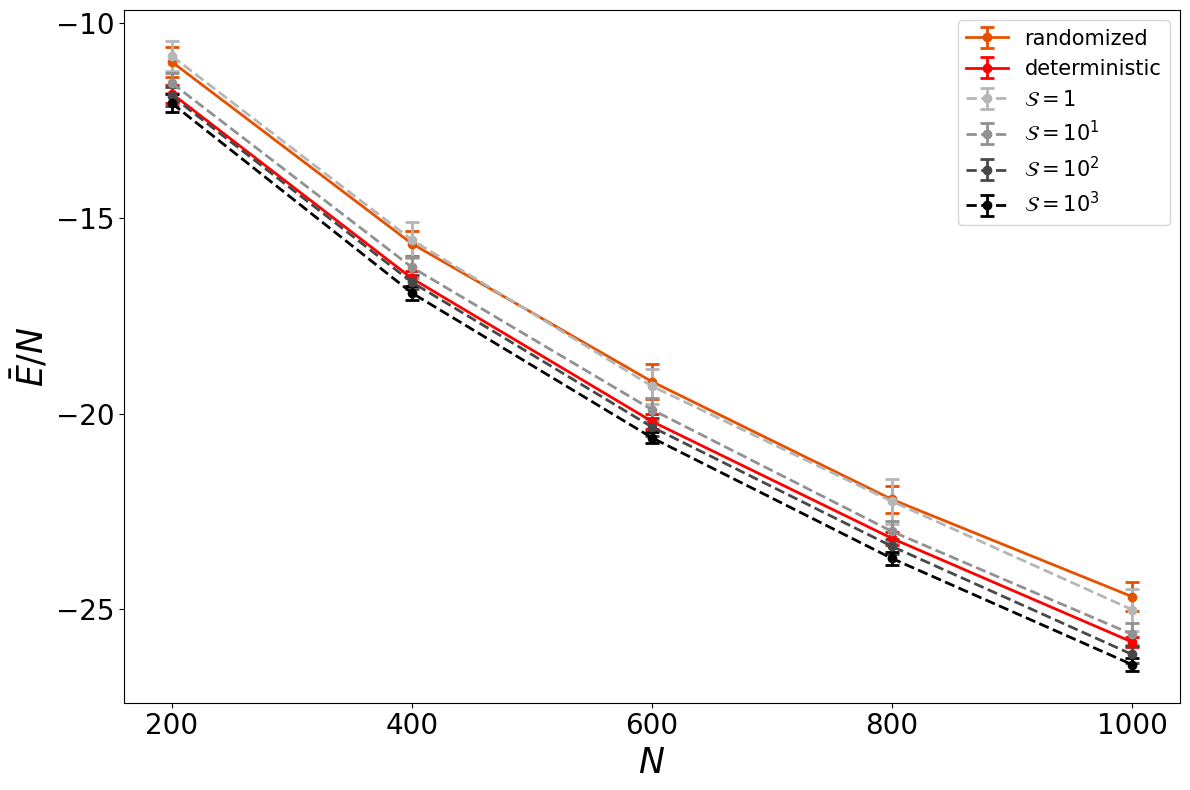

In [11]:
colors = [f"#{i:02x}{i:02x}{i:02x}" for i in np.linspace(0, 255,8).astype(int)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-10, -15, -20, -25], fontsize=20)
plt.errorbar(task, randm_ave, yerr=randm_yerr, fmt="o", linestyle="-", lw=2, ecolor="#E65100", capsize=5, capthick=2, color="#E65100", label="randomized")
plt.errorbar(task, deter_ave, yerr=deter_yerr, fmt="o", linestyle="-", lw=2, ecolor="red", capsize=5, capthick=2, color="red", label="deterministic")
plt.errorbar(task, r0_ave, yerr=r0_yerr, fmt="o", linestyle="--", lw=2, ecolor=colors[5], capsize=5, capthick=2, color=colors[5], label=r"$\mathcal{S}=1$")
plt.errorbar(task, r1_ave, yerr=r1_yerr, fmt="o", linestyle="--", lw=2, ecolor=colors[4], capsize=5, capthick=2, color=colors[4], label=r"$\mathcal{S}=10^1$")
plt.errorbar(task, r2_ave, yerr=r2_yerr, fmt="o", linestyle="--", lw=2, ecolor=colors[2], capsize=5, capthick=2, color=colors[2], label=r"$\mathcal{S}=10^2$")
plt.errorbar(task, r3_ave, yerr=r3_yerr, fmt="o", linestyle="--", lw=2, ecolor="black", capsize=5, capthick=2, color="black", label=r"$\mathcal{S}=10^3$")
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$\bar{E}/N$", fontsize=25)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

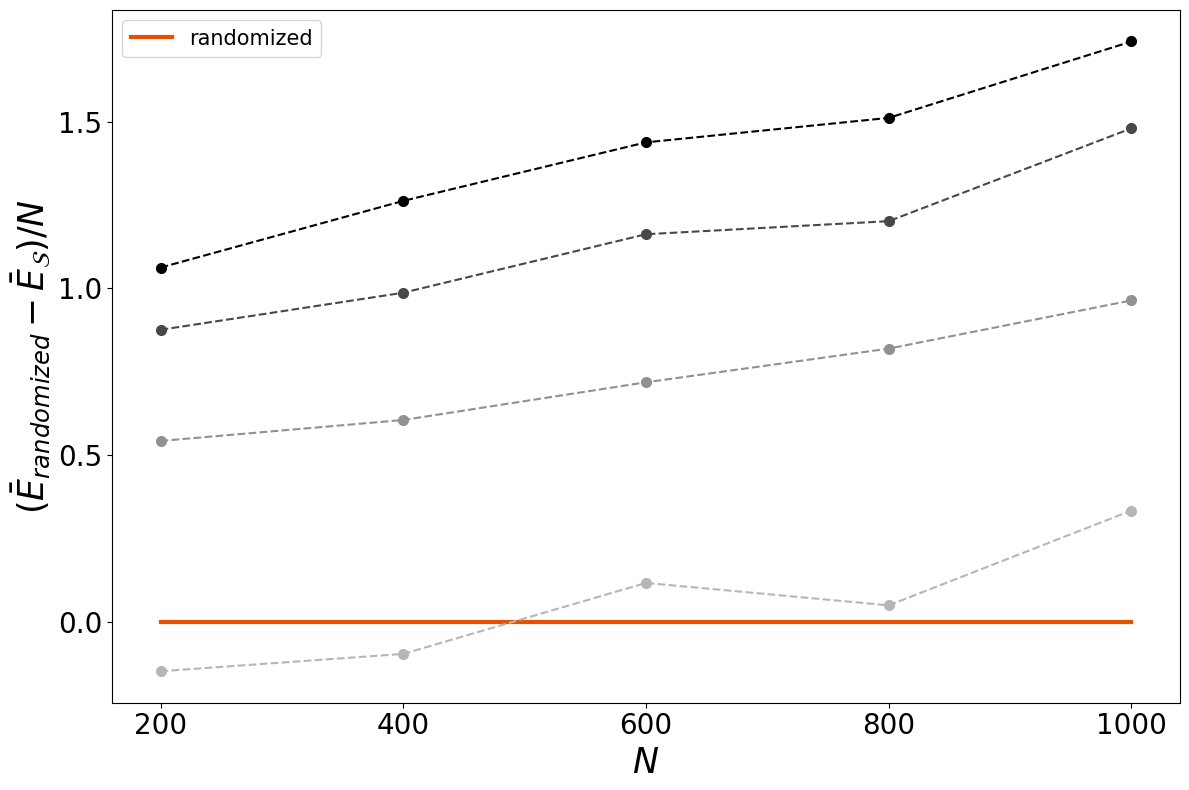

In [12]:
randm_diff_0 = [randm_ave[i] - r0_ave[i] for i in range(5)]
randm_diff_1 = [randm_ave[i] - r1_ave[i] for i in range(5)]
randm_diff_2 = [randm_ave[i] - r2_ave[i] for i in range(5)]
randm_diff_3 = [randm_ave[i] - r3_ave[i] for i in range(5)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=20)
plt.plot(task,np.full_like(task,0),color="#E65100",linestyle='-',linewidth=3, label="randomized")
plt.plot(task, randm_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7)
plt.plot(task, randm_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7)
plt.plot(task, randm_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7)
plt.plot(task, randm_diff_3, color="black", linestyle='--',marker='o', markersize=7)
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{randomized}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()

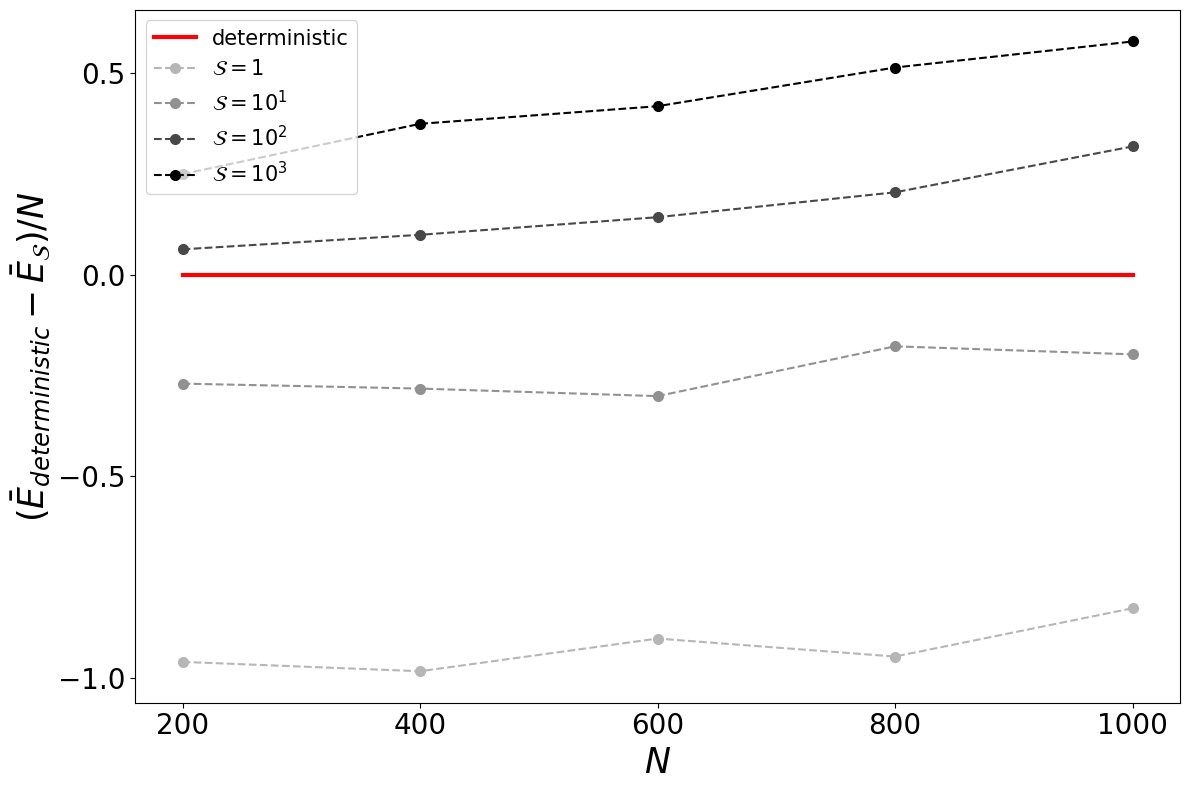

In [13]:
deter_diff_0 = [deter_ave[i] - r0_ave[i] for i in range(5)]
deter_diff_1 = [deter_ave[i] - r1_ave[i] for i in range(5)]
deter_diff_2 = [deter_ave[i] - r2_ave[i] for i in range(5)]
deter_diff_3 = [deter_ave[i] - r3_ave[i] for i in range(5)]

plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-1.5, -1, -0.5, 0, 0.5], fontsize=20)
plt.plot(task,np.full_like(task,0),color="red",linestyle='-',linewidth=3, label="deterministic")
plt.plot(task, deter_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=1$")
plt.plot(task, deter_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=10^1$")
plt.plot(task, deter_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=10^2$")
plt.plot(task, deter_diff_3, color="black", linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=10^3$")
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{deterministic}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()